In [15]:
import re
import pickle
from pprint import pprint
from collections import Counter
import os
import numpy as np
import pandas as pd


class MorphemeError(Exception):
    '''raised if morpheme is empty'''
    def __init__(self, message='Length of lists not equal'):
        super(MorphemeError, self).__init__()
        self.message = message
    def __str__(self):
        return repr(self.message)


class Morphemes():


    def __init__(self, content, corpus):
        self.content = content
        self.corpus = corpus
        self.morphemes = self.morpheme_count()
        if '0' in self.morphemes or 0 in self.morphemes:
            raise MorphemeError('0 morphemes in morpheme_count')
        self.raw_speakers = self.raw_speaker_count()
        self.speakers = self.speaker_count() # expected values for DP
        self.mbs = self.morpheme_by_speaker_count() # observed values for DP


    def morpheme_count(self):
        '''returns dict with overall count for morphemes (ignoring speakers)'''
        print('counting morphemes...')
        items = [x[:3] for x in self.content if x[0][0] in '-=' and not '-ep' in x]
        return Counter(items)

    
    def raw_morpheme_by_speaker_count(self):
#     '''generates dict morheme: Counter(by speaker) with number of times speaker said this morpheme'''
        alll = {}
        for morpheme in self.morphemes:
            count = Counter([x[-1] for x in self.content if x[:3]==morpheme])
            res = {x: count[x] for x in count}
            mor = '-'.join(list(map(lambda x: x.strip('-='), morpheme)))
            alll[mor] = res
        return alll
    
    
    def morpheme_by_speaker_count(self):
        '''generates dict morheme: Counter(by speaker) with proportion of this speaker in the 
        overall count of this morpheme'''
        print('counting observed values...')
        alll = {}
        for morpheme in self.morphemes:
            count = Counter([x[-1] for x in self.content if x[:3]==morpheme])
            res = {x: count[x]/self.morphemes[morpheme] for x in count}
            mor = '-'.join(list(map(lambda x: x.strip('-='), morpheme)))
            alll[morpheme] = res
        return alll

    def speaker_by_morpheme_count(self):
        '''generates dict morpheme: Counter(by speaker) with frequency of this morpheme in this speakers speech'''
        alll = {}
        for morpheme in self.morphemes:
            count = Counter([x[-1] for x in self.content if x[:3]==morpheme])
            res = {x: count[x]/self.raw_speakers[x] for x in count}
            alll[morpheme] = res
        return alll

    
    def sp_by_pos(self):
        '''returns dict speaker: Counter(pos: prop of words with that pos in this speaker's speech)'''
        alll = {}
        for speaker in self.speakers:
            count = Counter([x[-2] for x in self.content if x[-1]==speaker])
            res = {x: count[x]/self.raw_speakers[x] for x in count}
            alll[speaker] = res
        return alll
    
    
    def pos_by_sp(self):
        '''returns dict speaker: Counter(pos: prop of this speaker in this pos)'''
        alll = {}
        poss = Counter([x[-2] for x in self.content])
        for pos in poss:
            count = Counter([x[-1] for x in self.content if x[-2]==pos])
            res = {x: count[x]/poss[pos] for x in count}
            alll[pos] = res
        return alll
    

    def calculate_dp(self):
        '''well, calculates dp for all morphemes'''
        print('counting DP...')
        res = {'morpheme': [], 'count': [], 'dp': []}
        for sp in self.speakers:
            res[sp] = []
#         sp_by_mor = self.speaker_by_morpheme_count() # это было нужно для частотностей
        for mor in self.mbs:
#             sp_count = sp_by_mor[mor]
            counts = self.mbs[mor]
            res['morpheme'].append('-'.join(list(map(lambda x: x.strip('-='), mor))))
            res['count'].append(self.morphemes[mor])
            res['dp'].append(dp(self.speakers, counts))
            if not sum(counts.values()) > 0.999:
                print(mor)
                print(self.morphemes[mor])
                pprint(counts)
                print(sum(counts.values()))
                raise MorphemeError('sum not equals 1')
            for sp in self.speakers:
                if sp in counts:
                    res[sp].append(counts[sp])
                else:
                    res[sp].append(0)
        print(len(res['AAS']))
        return res


    def raw_speaker_count(self):
        '''returns dict with the number of words every speaker said in a corpus'''
        print('counting speakers...')
        items = [x[-1] for x in self.content if x[0]=='END']
        return Counter(items)


    def speaker_count(self, totals = {'Kamchatka': 33112, 'Sebjan': 49800}):
        '''returns dict with proportions of every speaker in a corpus'''
        print('counting expected values...')
        res = {x: self.raw_speakers[x]/totals[self.corpus] for x in self.raw_speakers}
        # pprint(res)
        # print(sum(res.values()))
        return res


def dp(expected, observed):
    # step = {sp: expected[sp]-observed[sp] if sp in observed else expected[sp] for sp in expected}
    deltas = []
    for sp in expected:
        if sp in observed:
            delta = np.abs(expected[sp]-observed[sp])
        else:
            delta = 0
        deltas.append(delta)
    dp = sum(deltas) / 2
    return dp



def main():
    corpora = ['Kamchatka', 'Sebjan']
    corp_pd = []
    for corp in corpora:
        print('handling {}...'.format(corp))
        with open('../{}_wds_by_mor.pickle'.format(corp), 'rb') as f:
            mor = Morphemes(pickle.load(f), corp)
        res = mor.calculate_dp()
        print(res['AAS'][:10])
        columns = ['morpheme', 'count', 'dp'] + sorted(list(mor.speakers.keys()))
        a = pd.DataFrame(res).loc[pd.DataFrame(res)['count']>15].sort_values('dp', ascending=False)[columns] 
        print(a['count'].head())
        #.to_excel('{}_dp_new.xlsx'.format(corp))
        corp_pd.append(a)
        print('{} done'.format(corp))
    print('all done')
    return corp_pd


if __name__ == '__main__':
    # unittest.main()
    a = main()



handling Kamchatka...
counting morphemes...
counting speakers...
counting expected values...
counting observed values...
counting DP...
672
[0.009876543209876543, 0, 0.02697841726618705, 0.06779661016949153, 0.08379888268156424, 0.010526315789473684, 0, 0.022222222222222223, 0.0031380753138075313, 0.014459415050936576]
293    39
42     16
287    16
114    42
358    17
Name: count, dtype: int64
Kamchatka done
handling Sebjan...
counting morphemes...
counting speakers...
counting expected values...
counting observed values...
counting DP...
659
[0.014911014911014911, 0, 0.044709388971684055, 0.006544502617801047, 0.003795066413662239, 0, 0.020833333333333332, 0.01060070671378092, 0.012138728323699421, 0.02333931777378815]
343    66
120    19
422    30
150    18
33     24
Name: count, dtype: int64
Sebjan done
all done


In [20]:
a[0]['AAS_k'] = a[0]["AAS"]
del a[0]["AAS"]

Надо понять что мне нужно

мне нужен

- список всех спикеров +
- список нужных морфем +

надо почистить спикеров по тому, что говорила Бригитта

ptc и ptcp не исправлены! аааааа


In [16]:
a[0].head()

,morpheme,count,dp,AAS,AEI,AFI,AGK,AL,AMG,AS,...,NFI,NIG,NMK,ONI,PMB,RME,RMS,TEB,VIA,rh
293,eː-emph-adj,39,0.440800,0.000000,0.102564,0.0,0.0,0,0.000000,0.025641,...,0.025641,0.025641,0.00000,0.0000,0.025641,0.076923,0.025641,0.0,0.0000,0.0
42,WEːČ-gnr.nonfut-v,16,0.430871,0.000000,0.000000,0.0,0.0,0,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.0625,0.000000,0.000000,0.000000,0.0,0.8125,0.0
287,LE-nr-n,16,0.426613,0.000000,0.000000,0.0,0.0,0,0.062500,0.000000,...,0.000000,0.562500,0.00000,0.0000,0.062500,0.062500,0.062500,0.0,0.0000,0.0
114,n-nr-n,42,0.424671,0.071429,0.000000,0.0,0.0,0,0.047619,0.047619,...,0.071429,0.071429,0.02381,0.0000,0.000000,0.071429,0.142857,0.0,0.0000,0.0
358,El-emph-adv,17,0.416208,0.000000,0.000000,0.0,0.0,0,0.000000,0.000000,...,0.117647,0.000000,0.00000,0.0000,0.000000,0.117647,0.000000,0.0,0.0000,0.0


In [17]:
# здесь достаются морфемы с которыми работаем
n = ['ptc', 'cvb', 'loc', 'dat', 'all']
n_0 = [x for x in list(a[0]['morpheme']) if any([y in x for y in n])]
n_1 = [x for x in list(a[1]['morpheme']) if any([y in x for y in n])]
print(len(n_0))
print(len(n_1))
needed = sorted(list(set(n_0)&set(n_1)))
pprint(needed)

20
22
['(dU)LE-loc-n',
 '(dU)LE-loc-v',
 'DE-purp.cvb-v',
 'DU-dat-n',
 'R-neg.cvb-v',
 'REk-cond.cvb-v',
 'RI-impf.ptc-v',
 'RIdʒI-ant.cvb-v',
 'mI-cond.cvb-v',
 'nIkEn-sim.cvb-v',
 'skI-advb.all-rel.n',
 't(E)kI-all-n',
 't(E)kI-all-pron',
 'čE-pf.ptc-v']


In [18]:
k_speakers = list(a[0].columns[3:])
s_speakers = list(a[1].columns[4:])
all_speakers = k_speakers + s_speakers

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
def sort_to_two(A, B):
    C = {}
    C.update(A)
    C.update(B)
    res_keys = sorted(C, key=C.get)
    res_values = sorted(C.values())
    res_A = [res_values[i] if res_keys[i] in A else 0 for i in range(len(res_values))]
    res_B = [res_values[i] if res_keys[i] in B else 0 for i in range(len(res_values))]
    i = delete_zeros(res_A, res_B)
    return res_A[i:], res_B[i:], res_keys[i:]
    

def delete_zeros(res_A, res_B):
    i = 0
    while res_A[i] == 0 and res_B[i] == 0:
        i+= 1
#         print(i)
    return i

def make_dict(row, speakers):
    '''делает словарь спикер: частотность'''
    res = {}
    for sp in speakers:
        try:
            res[sp] = row[sp].iloc[0]
        except:
            print(row)
            print(speakers)
            raise Exception
#             res[sp] = 0
    return res


def calc_dp(k_count, s_count):
    '''считает дипи для двух корпусов как двух коробок'''
    total = k_count + s_count
    exp = np.array([33112/(49800+33112), 49800/(49800+33112)])
    obs = np.array(k_count/total, s_count/total)
    res = np.sum(np.abs(exp-obs))/2
    return res

from scipy.stats import beta

def binom_interval(success, total, confint=0.95):
    quantile = (1 - confint) / 2.
    lower = beta.ppf(quantile, success, total - success + 1)
    upper = beta.ppf(1 - quantile, success + 1, total - success)
    return (lower, upper)

Для конфинта нужны

- сырые частотности по спикерам (не делённые!)
- количество слов по спикерам

их надо подготовить (в след. ячейке)

считается proportion_confint(raw_count, raw_speaker)

In [5]:
corpora = ['Kamchatka', 'Sebjan']
morphemes_cl = []
for corp in corpora:
    with open('../{}_wds_by_mor.pickle'.format(corp), 'rb') as f:
        mor = Morphemes(pickle.load(f), corp)
    morphemes_cl.append(mor)
    
raw_m_k = morphemes_cl[0].raw_morpheme_by_speaker_count()
raw_m_s = morphemes_cl[1].raw_morpheme_by_speaker_count()
k_raw_speakers = morphemes_cl[0].raw_speaker_count()
s_raw_speakers = morphemes_cl[1].raw_speaker_count()

Собственно конфинты

In [6]:
def yerrs(morpheme, res_x):
    k_m_by_s = raw_m_k[morpheme]
    s_m_by_s = raw_m_s[morpheme]
    k_yerr = get_yerr(res_x, k_m_by_s, k_raw_speakers)
    s_yerr = get_yerr(res_x, s_m_by_s, s_raw_speakers)
    print(res_x)
    pprint(len(s_yerr))
    for x, y in zip(res_x, k_yerr):
        print(x, y)
    k_yerr = [[x[0] for x in k_yerr], [x[1] for x in k_yerr]]
    s_yerr = [[x[0] for x in s_yerr], [x[1] for x in s_yerr]]
    return k_yerr, s_yerr
    

def get_yerr(order, m_by_s, raw_speakers):
    yerr = []
    for sp in order:
        if sp == "AAS_k":
            sp = "AAS"
        if sp in m_by_s:
#             if 'AMG' in raw_speakers and sp == 'AAS':
#                 print('found')
#                 sp = "AAS"
#                 print(sp)
            raw_count = m_by_s[sp]
            raw_sp = raw_speakers[sp]
            ci = binom_interval(raw_count, raw_sp)
            print(sp, ci)
            yerr.append(ci)
        else:
            yerr.append((0, 0))
    return yerr

Здесь кусок кода который делает графики

In [21]:
corp = 'Kamchatka'
with open('../{}_wds_by_mor.pickle'.format(corp), 'rb') as f:
    kam = Morphemes(pickle.load(f), corp)
corp = "Sebjan"
with open('../{}_wds_by_mor.pickle'.format(corp), 'rb') as f:
    seb = Morphemes(pickle.load(f), corp)

sorted(kam.morphemes, key=kam.morphemes.get, reverse=True)[:11]

counting morphemes...
counting speakers...
counting expected values...
counting observed values...
counting morphemes...
counting speakers...
counting expected values...
counting observed values...


[('-R(E)', '-nonfut', 'v'),
 ('-RI', '-pst', 'v'),
 ('-WEːČ', '-gnr', 'v'),
 ('-W', '-acc', 'n'),
 ('-n(I)', '-3sg', 'v'),
 ('-D', '-prog', 'v'),
 ('-n(I)', '-poss.3sg', 'v'),
 ('-(dU)LE', '-loc', 'n'),
 ('-m', '-1sg', 'v'),
 ('-n(I)', '-poss.3sg', 'n'),
 ('-L', '-pl', 'n')]

In [22]:
k_part = 33112/(49800+33112)
s_part = 49800/(49800+33112)
k_speakers = kam.speakers.keys()
s_speakers = seb.speakers.keys()
k_exp = np.array([kam.speakers[x] for x in k_speakers])*k_part
s_exp = np.array([seb.speakers[x] for x in s_speakers])*s_part

In [ ]:

overall = 

In [107]:
dps1 = []
dps2 = []
dpsk = []
dpss = []
for mor in needed:
    row_k = a[0].loc[a[0]['morpheme']==mor]
    k = make_dict(row_k, k_speakers)
    row_s = a[1].loc[a[1]['morpheme']==mor]
    s = make_dict(row_s, s_speakers)
    print(sum(k.values()))
    dp_1 = calc_dp(row_k['count'].iloc[0], row_s['count'].iloc[0])
    k_obs = np.array([kam.mbs[mor][sp] if sp in kam.mbs[mor] else 0 for sp in k_speakers])*k_part
    s_obs = np.array([seb.mbs[mor][sp] if sp in seb.mbs[mor] else 0 for sp in s_speakers])*s_part
    deltas = np.array([*k_exp, *s_exp])-np.array([*k_obs, *s_obs])
    dp_2 = np.sum(np.abs(deltas))/2
    dps1.append(dp_1)
    dps2.append(dp_2)
    dpsk.append(row_k['dp'].iloc[0])
    dpss.append(row_s['dp'].iloc[0])
#     k = {sp:(kam.speakers[sp]-kam.mbs[mor][sp])*k_part if sp in kam.mbs[mor] else 0 for sp in k_speakers}
#     s = {sp:(seb.speakers[sp]-seb.mbs[mor][sp])*s_part if sp in seb.mbs[mor] else 0 for sp in s_speakers}
#     # now sort
#     res_k, res_s, res_x = sort_to_two(k, s)
#     print(set(s_speakers)&set(k_speakers))
# #     print(k)
#     print(res_s)
#     fig, ax = plt.subplots(figsize=(25, 10))
#     x = np.arange(len(res_x))
# #     yerr = yerrs(mor, res_x)
#     plt.xticks(rotation=70)
#     ax.bar(x, res_k, color="red")#, yerr=yerr[0])
#     ax.bar(x, res_s, color="cyan")#, yerr=yerr[1])
#     plt.xticks(x, res_x)
# #     dp_k = row_k['dp'].iloc[0]
# #     dp_s = row_s['dp'].iloc[0]
# #     diff = dp - min(dp_k, dp_s)
#     plt.title("{}".format(mor))
#     plt.text(0, max(*res_k, *res_s)/2, "DP:{}".format(dp))#, \ndiff: {}, \nDP K: {}, \nDP S: {}".format(dp, diff, dp_k, dp_s))
#     plt.legend(['Kamchatka', 'Sebjan'])
#     if not os.path.exists("pics"):
#         os.mkdir('pics')
#     fig.savefig('pics/{}.png'.format(mor))
#     plt.show()
#     break

0.969096207188
0.02974754112
0.319827334093
0.507579361256
0.321512225153
0.168399331695
0.0758124137065
0.2341946428
0.171767980174
0.0595081875812
0.015585721928
0.289246130576
0.110633953112
0.200578987083


In [104]:
pd.DataFrame({"affix": needed, 'two-part': dps1, 'together': dps2, 'k': dpsk, "s": dpss}).to_csv('dps.csv')

In [55]:
np.sum(row_k[row_k.columns[3:]].iloc[0])

0.9690962071879287

In [24]:
# k_raw_speakers

# print(raw_m_k['(dU)LE-loc-n'])
# print(raw_m_s['(dU)LE-loc-n'])

# morphemes_cl[0].raw_morpheme_by_speaker_count()

a[0].loc[a[0]['morpheme']==mor]

from statsmodels.stats.proportion import proportion_confint

from scipy import nan

"AMG" in s_raw_speakers

# raw_m_k["(dU)LE-loc-n"]

,morpheme,count,dp,AEI,AFI,AGK,AL,AMG,AS,ASA,...,NIG,NMK,ONI,PMB,RME,RMS,TEB,VIA,rh,AAS_k
10,(dU)LE-loc-n,1044,0.095194,0.022712,0.061947,0.031746,0,0.0125,0.032334,0.014563,...,0.027682,0.036508,0.073099,0.041359,0.02976,0.034907,0.044601,0.028743,0.0,0.032023


А теперь мне нужно сделать табличку с десятью самыми частотными морфемами и DP для них.

- найти 10 самых частотных +
- дропать эпентезы +
- написать фц для подсчёта DP по-Даниэлевски
- сделать табличку

нам нужно
- ожидаемое значение (self.speaker_count\*totals/сумму)
- наблюдаемое значение (self.morpheme_by_speaker_count\*то же)

вот и всё

In [81]:
k_part = 33112/(49800+33112)
s_part = 49800/(49800+33112)
k_speakers = kam.speakers.keys()
s_speakers = seb.speakers.keys()
k_exp = np.array([kam.speakers[x] for x in k_speakers])*k_part
s_exp = np.array([seb.speakers[x] for x in s_speakers])*s_part

for mor in needed:
    k_obs = np.array([kam.mbs[mor][sp] if sp in kam.mbs[mor] else 0 for sp in k_speakers])*k_part
    s_obs = np.array([seb.mbs[mor][sp] if sp in seb.mbs[mor] else 0 for sp in s_speakers])*s_part
    print(np.sum(np.abs(np.array([*k_exp, *s_exp])-np.array([*k_obs, *s_obs])))/2)

0.0937218307064
0.47713598395
0.20117597537
0.187034335217
0.148158013208
0.199633969169
0.221812154534
0.223476913615
0.231593794073
0.26031942946
0.457502013296
0.355641007118
0.309329461255
0.28635217328


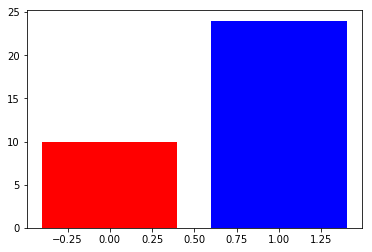

In [90]:
plt.bar([0, 1], [10, 24], color=['red', 'blue'])
plt.show()

In [109]:
class Spam:
    def __new__(self):
        self.__init__(self)
        print(1)
    
    def __init__(self):
        print(2)

class E(Spam):
    def __new__(self):
        print(3)
        
    def __init__(self):
        print(4)


In [120]:
cmp()

True

In [ ]:
plt.bar(kam, c="red", xticks=)
plt.bar(seb, c="blue")